In [785]:
import numpy as np
from numba import jit
from numba import njit
import matplotlib.pyplot as plt

In [786]:
N = 20
L = 10.0
h = 0.002
epsilon = 1
sigma = 1
m = 1
v_0 = 1

Time = 10
time = np.arange(0, Time, h)
f = open("datos.txt", "w")
f_energia = open("energia.txt", "w")

Definir funciones para el programa:

Notación:
- L, indica la longitud de la caja
- T, tiempo total a calcular
- r, matriz con posiciones de las partículas. Tiene dimensiones (N, 2), con N el número de partículas
- R, matriz con la distancia entre partículas

In [787]:
@jit(nopython=True)
def init_cond():
    r = np.zeros((N, 2))
    v =np.zeros((N, 2))
    for i in range(N):
        r[i] = np.array([i%(L/2)*2+1, i%4*2 +1 ]) + 1* np.random.rand(1, 2)[0]
        # r[i] = np.array([i%(L/2)*2+1, i%4*2.5 +1 ])
        theta = np.random.rand()*2*np.pi
        v[i] = v_0 * np.array([np.sin(theta), np.cos(theta)])
    return r, v

@jit(nopython=True)
def cond_contorno(r):
    if(r[0] > L):
        r[0] = r[0] - L
    if(r[0] < 0):
        r[0] = r[0] + L
    if(r[1] > L):
        r[1] = r[1] - L
    if(r[1] < 0):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def cond_contorno_distancia(r):
    if(r[0] > L/2):
        r[0] = r[0] - L
    elif(r[0] < -L/2):
        r[0] = r[0] + L
    if(r[1] > L/2):
        r[1] = r[1] - L
    elif(r[1] < -L/2):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def lennard_jones(r):
    R = compute_distance(r)
    acc = np.zeros((N, 2))
    for i in range(N):
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                if (norm < 3):
                    acc[i] = acc[i] + 4*R[i, j]* epsilon * (6*np.power((sigma/norm), 5) - 12*np.power((sigma/norm), 11))/(norm*m)
    return acc, R

@jit(nopython=True)
def compute_distance(r):
    R = np.zeros((N, N, 2))
    for i in range(0, N-1):
        for j in range(i+1, N):
            R[i, j] = r[j]- r[i]
            R[i, j] = cond_contorno_distancia(R[i, j])
            R[j, i] = -R[i, j]
    return R

@jit(nopython=True)
def verlet_algorithm(r, v, a):
    w = np.zeros((N, 2))
    for i in range(N):
        r[i] = r[i] + h*v[i] + h*h*a[i]/2
        r[i] = cond_contorno(r[i])
        w[i] = v[i] + h*a[i]/2
    a, R = lennard_jones(r)
    for i in range(N):
        v[i] = w[i] + h*a[i]/2
    return r, v, a, R

@jit(nopython=True)
def compute_energy(v, R):
    T = 0
    V = 0
    for i in range(N):
        T = T + 0.5*m*np.linalg.norm(v[i])**2
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                V = V + 4*epsilon * (np.power((sigma/norm), 12) - np.power((sigma/norm), 6))
    return T, V

def write_vector(r):
    for i in range(N):
        f.write(f"{r[i, 0]}, {r[i, 1]}\n")
    f.write(f"\n")

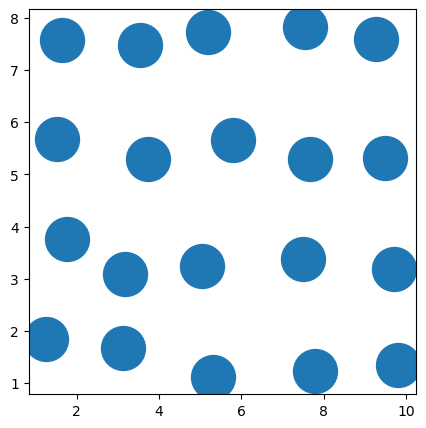

In [788]:
T, V = np.zeros(len(time)), np.zeros(len(time))

r, v = init_cond()
write_vector(r)
a, R = lennard_jones(r)
T[0], V[0] = compute_energy(v, R)
f_energia.write(f"{T[0]}, {V[0]}\n")
fig=plt.figure(figsize=(5,5)) #Size of the plot
ax=fig.add_subplot(111)
plt_xlim = (0, L)
plt_ylim = (0, L)
plt.scatter(r[:,0], r[:,1], s=1000)

for i in range(1, len(time)):
    r, v, a, R = verlet_algorithm(r, v, a)
    T[i], V[i] = compute_energy(v, R)
    write_vector(r)
    f_energia.write(f"{T[i]}, {V[i]}\n")

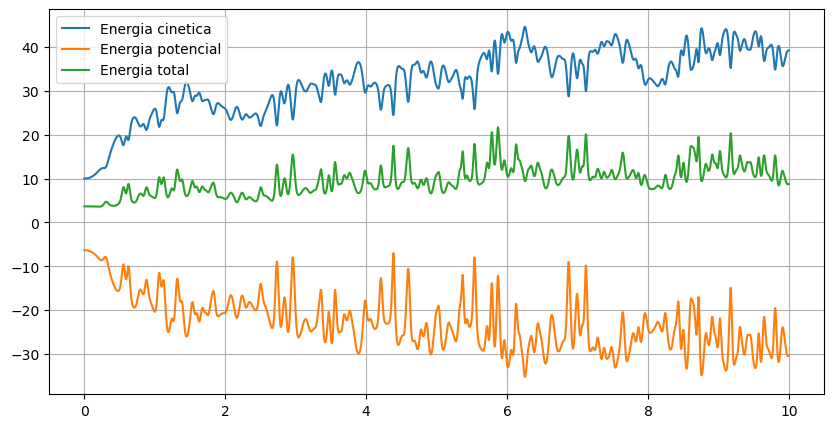

In [789]:
fig=plt.figure(figsize=(10,5)) #Size of the plot
ax=fig.add_subplot(111)

plt.plot(time, T, label="Energia cinetica")
plt.plot(time, V, label="Energia potencial")
plt.plot(time, T+V, label="Energia total")
plt.legend()
plt.grid()